In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from visualization.box_plots import quality_time_efficiency_box_plots, all_alg_feature_box_plot, box_plot
from visualization.quality_experiments import plots_with_correlation_heatmap, quality_scatter, get_corr, create_corr_df, initial_quality_to_quality_scatter
from visualization.cost_so_far import cost_so_far_plot, cost_so_far_m_instances


In [41]:
def create_short_name(x):
    match x:
        case "Greedy":
            return "G"
        case "Steepest":
            return "S"
        case "Heuristic":
            return "H"
        case "RandomSearch":
            return "RS"
        case "RandomWalk":
            return "RW"
        case _:
            return x

In [24]:
def set_efficiency_by_instance(row):
    min_time = df.query(f"Instance == '{row['Instance']}'")['Time'].min()
    max_time = df.query(f"Instance == '{row['Instance']}'")['Time'].max()
    return row['Quality'] / (1 + (row['Time'] - min_time) / (max_time - min_time))

In [42]:
def read_files_from_directory(directory, files):
    df = pd.DataFrame()
    for file in files:
        with open(os.path.join(directory, f"{file}Solver.csv"), "r") as f:
            algorithm_df = pd.read_csv(f, skiprows=1)
            algorithm_df.columns = ["Instance", "Time", "Cost", "Evaluations", "SlnChanges", "OptimalCost", "InitialCost", "TimeLimit", "SlnDistance"]
            
            # preprocessing
            algorithm_df["Algorithm"] = file
            algorithm_df["Time"] = (algorithm_df["Time"]).astype(int)
            algorithm_df['Quality'] = 1 - (algorithm_df['Cost']- algorithm_df['OptimalCost']) / algorithm_df['Cost']
            algorithm_df['InitialQuality'] = 1 - (algorithm_df['InitialCost']- algorithm_df['OptimalCost']) / algorithm_df['InitialCost']
            
            df = pd.concat([df, algorithm_df], ignore_index=True)
            
    df['AlgShortName'] = df['Algorithm'].apply(create_short_name)
    df['Efficiency'] = df.apply(set_efficiency_by_instance, axis='columns')

    return df

In [3]:
# directories = ["quadratic-assignment-problem/output/lipa", "quadratic-assignment-problem/output/chr"]
directories = ["quadratic-assignment-problem/output/chr2"]
algorithms = ["Greedy", "Steepest", "Heuristic", "RandomSearch", "RandomWalk"]

df = pd.concat([read_files_from_directory(directory, algorithms) for directory in directories], ignore_index=True)

In [48]:
initial_quality_df = read_files_from_directory("quadratic-assignment-problem/output/initial_quality", ["Greedy", "Steepest"])
# initial_quality_df.groupby(["Instance", "Algorithm"])["Instance"].describe()

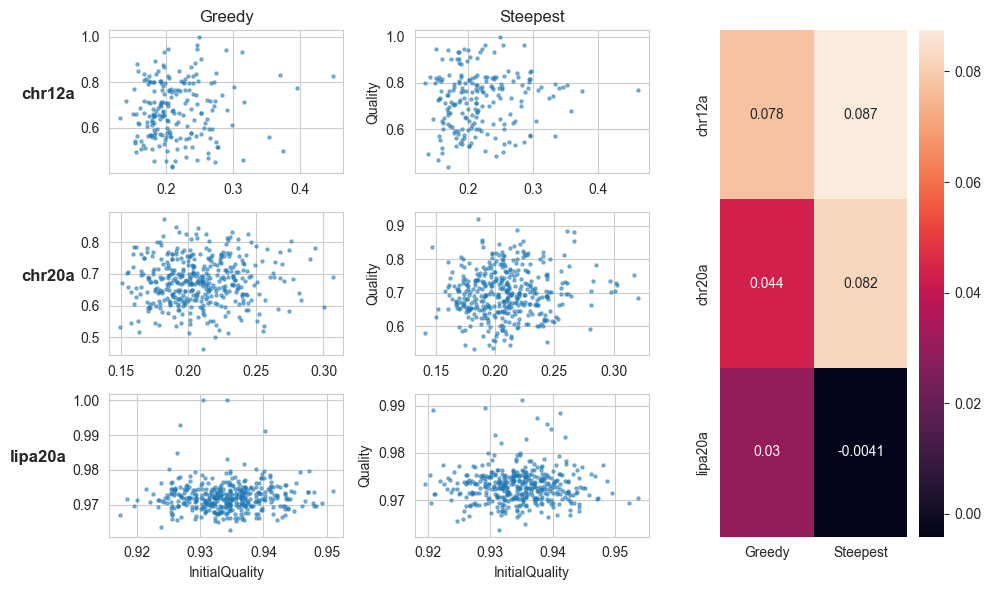

In [5]:
plt.figure(figsize=(10, 6))
axes = plots_with_correlation_heatmap(initial_quality_df)
plt.tight_layout()
# plt.savefig("report/pics/initial_quality_correlation_heatmap.png")
plt.show()

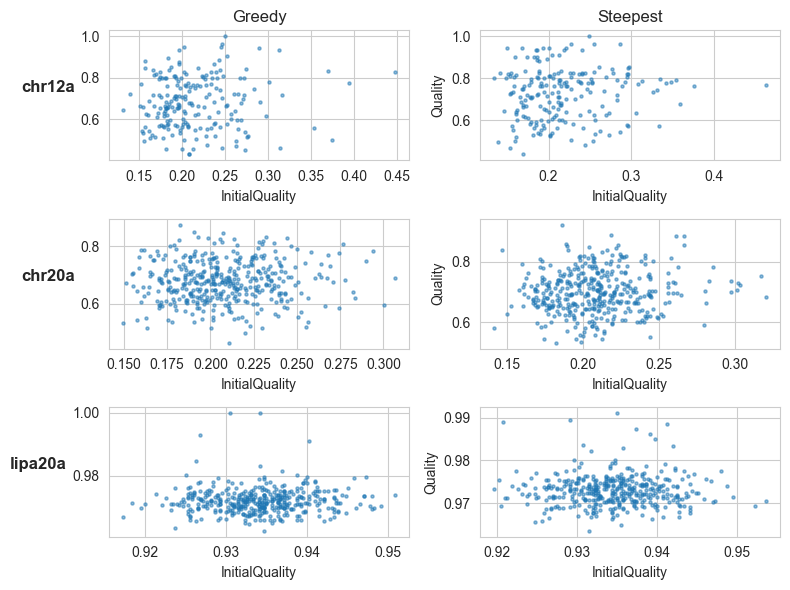

In [6]:
# initial_quality_to_quality_scatter(initial_quality_df)

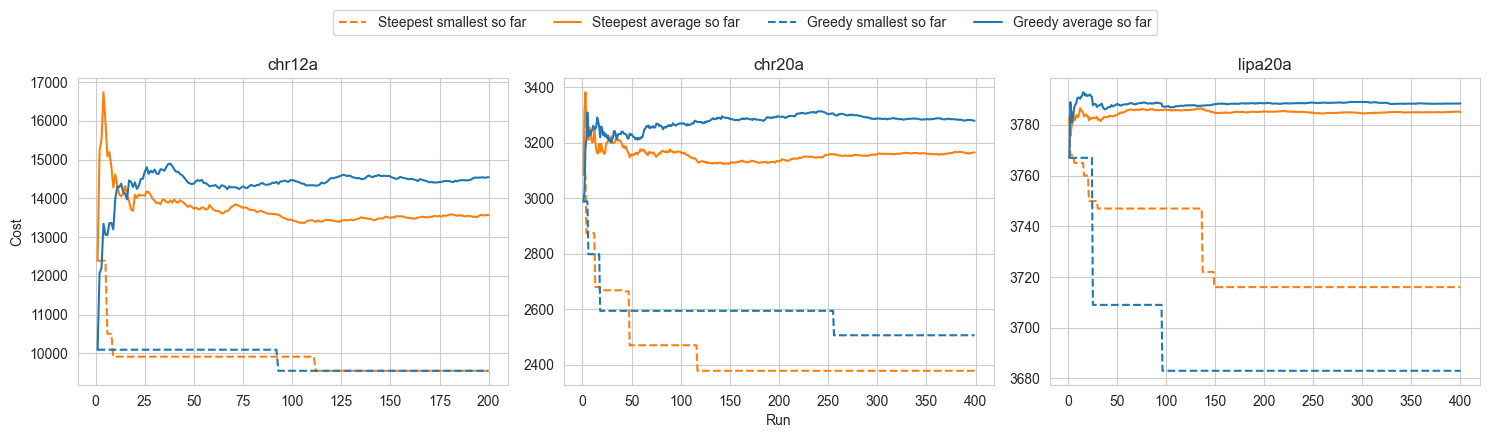

In [31]:
fig, axes = cost_so_far_m_instances(initial_quality_df)
plt.tight_layout()
# plt.savefig("report/pics/initial_quality_cost_so_far.png")
plt.show()

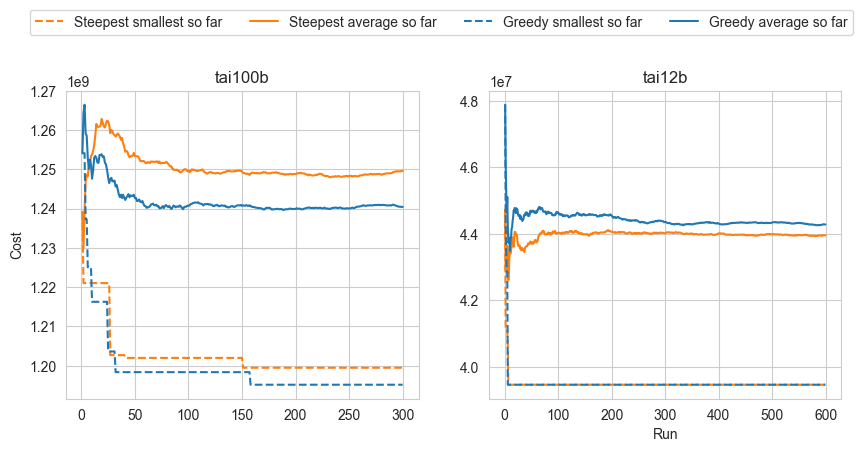

In [45]:
repetitions_df = read_files_from_directory("quadratic-assignment-problem/output/repetition", ["Greedy", "Steepest"])
# fig, axes = cost_so_far_m_instances(repetitions_df)

In [46]:
max_quality_row = repetitions_df[repetitions_df['Instance'] == 'tai100b'].nlargest(1, 'Quality')
# max_quality_row

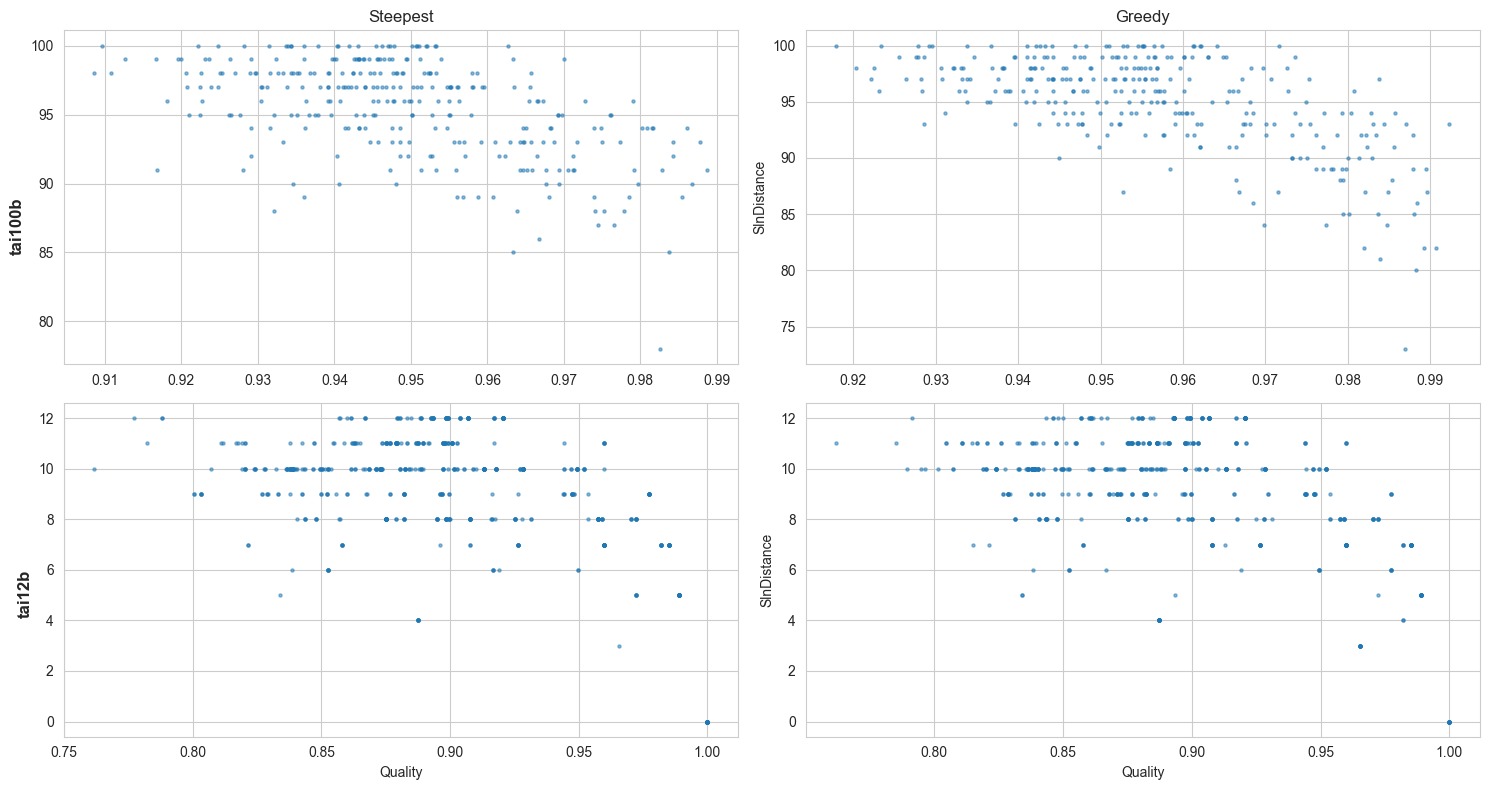

In [36]:
steepest_tai100b_distance_df = repetitions_df.query("(Instance == 'tai100b') and (Algorithm == 'Steepest')")
steepest_tai12b_distance_df = repetitions_df.query("(Instance == 'tai12b') and (Algorithm == 'Steepest')")
greedy_tai12b_distance_df = repetitions_df.query("(Instance == 'tai12b') and (Algorithm == 'Greedy')")
greedy_tai100b_distance_df = repetitions_df.query("(Instance == 'tai100b') and (Algorithm == 'Greedy')")


fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.ravel()
steepest_tai100b_distance_df.plot(kind='scatter', x ='Quality', y ='SlnDistance', s=5, alpha=0.5, ax=axes[0], title="Steepest")
greedy_tai100b_distance_df.plot(kind='scatter', x ='Quality', y ='SlnDistance', s=5, alpha=0.5, ax=axes[1], title="Greedy")
steepest_tai12b_distance_df.plot(kind='scatter', x ='Quality', y ='SlnDistance', s=5, alpha=0.5, ax=axes[2])
greedy_tai12b_distance_df.plot(kind='scatter', x ='Quality', y ='SlnDistance', s=5, alpha=0.5, ax=axes[3])

axes[0].set_ylabel("tai100b", rotation=90, ha='right', fontsize='large', fontweight='bold')
axes[2].set_ylabel("tai12b", rotation=90, ha='right', fontsize='large', fontweight='bold')
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
plt.tight_layout()
# plt.savefig("report/pics/repetitions_quality_distance_scatter.png")
plt.show()

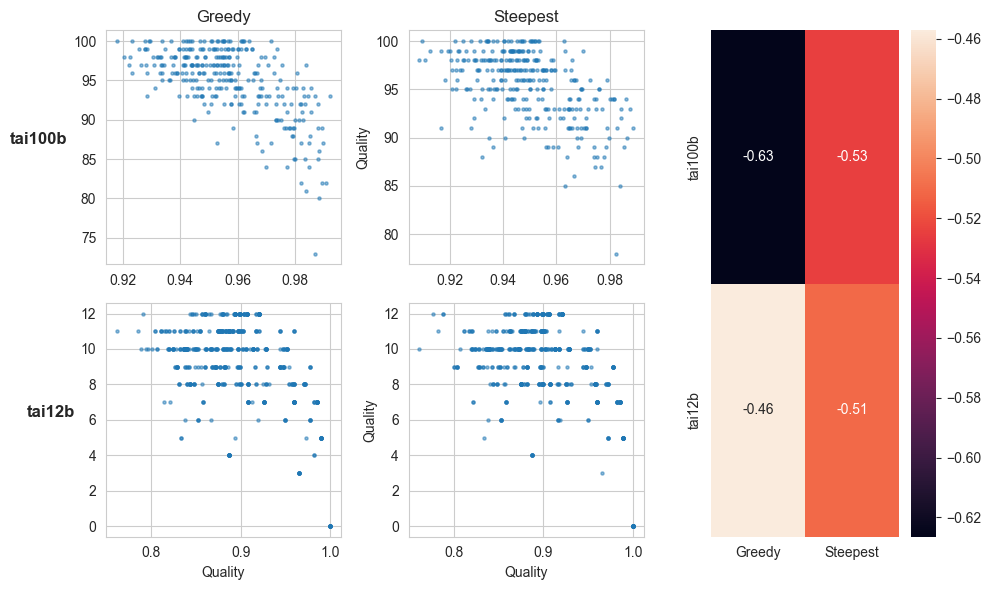

In [33]:
plt.figure(figsize=(10, 6))
axes = plots_with_correlation_heatmap(repetitions_df, features=("Quality", "SlnDistance"))
plt.tight_layout()
# plt.savefig("report/pics/repetitions_correlation_heatmap.png")
plt.show()

In [12]:
def plot_metrics(time_df, quality_df):
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot2grid((1, 3), (0, 0), )
    ax2 = plt.subplot2grid((1, 3), (0, 1), )
    ax3 = plt.subplot2grid((1, 3), (0, 2))

    quality_to_time_df = quality_df / time_df
    time_df.plot(kind='bar', ax=ax1, ylabel="Time (ns)", logy=True, xlabel=None)
    quality_df.plot(kind='bar', ax=ax2, ylabel="Quality")
    quality_to_time_df.plot(kind='bar', ax=ax3, ylabel="Quality/Time", logy=True)
    axs = [ax1, ax2, ax3]
    lines2, labels2 = axs[1].get_legend_handles_labels()
    for ax in axs[::]:
        ax.legend([])
        ax.set_xlabel(None)
    axs[1].set_xlabel("Instance")
    # fig.text(0.5, -0.05, 'Instance', ha='center', color='black', fontsize=12)
    lgd = fig.legend(lines2, labels2, loc='center left', bbox_to_anchor=(0.25, 1.05), ncols=5)
    plt.tight_layout()
    # plt.subplots_adjust(bottom=-1.2)  # Increase the bottom margin
    # plt.savefig("output.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

### Mean time and quality

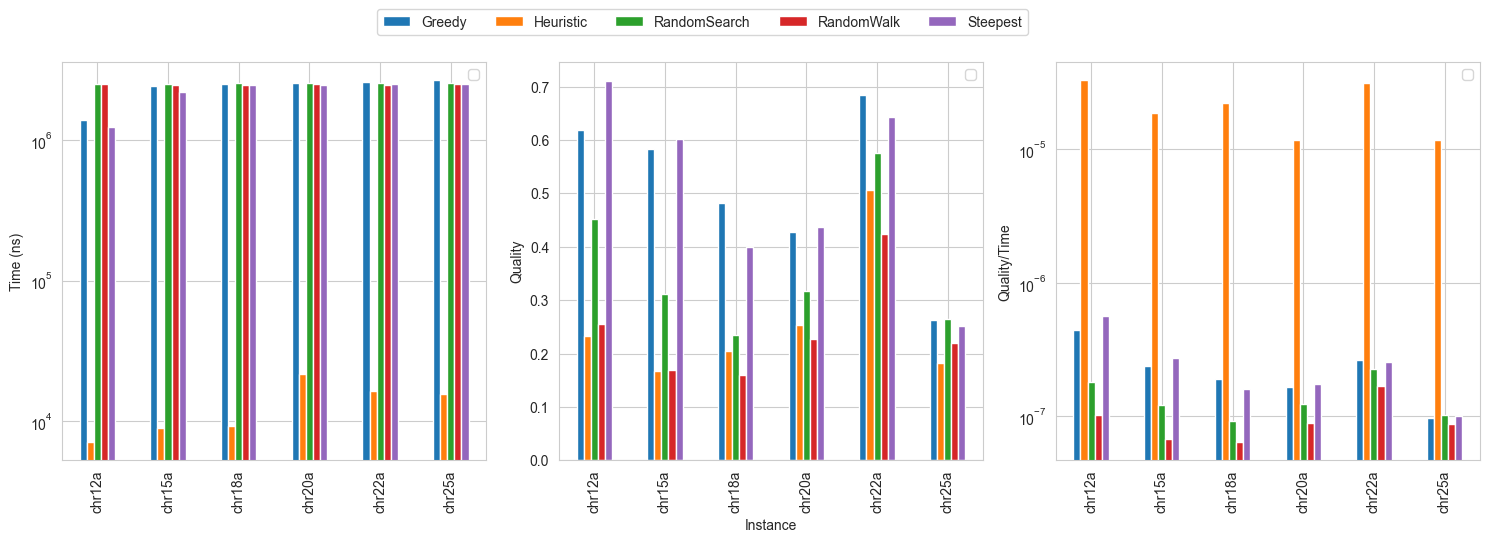

In [13]:
mean_time_df = df.groupby(["Instance", "Algorithm"])["Time"].mean().unstack()
mean_quality_df = df.groupby(["Instance", "Algorithm"])["Quality"].mean().unstack()
plot_metrics(mean_time_df, mean_quality_df)

### Worst time and quality

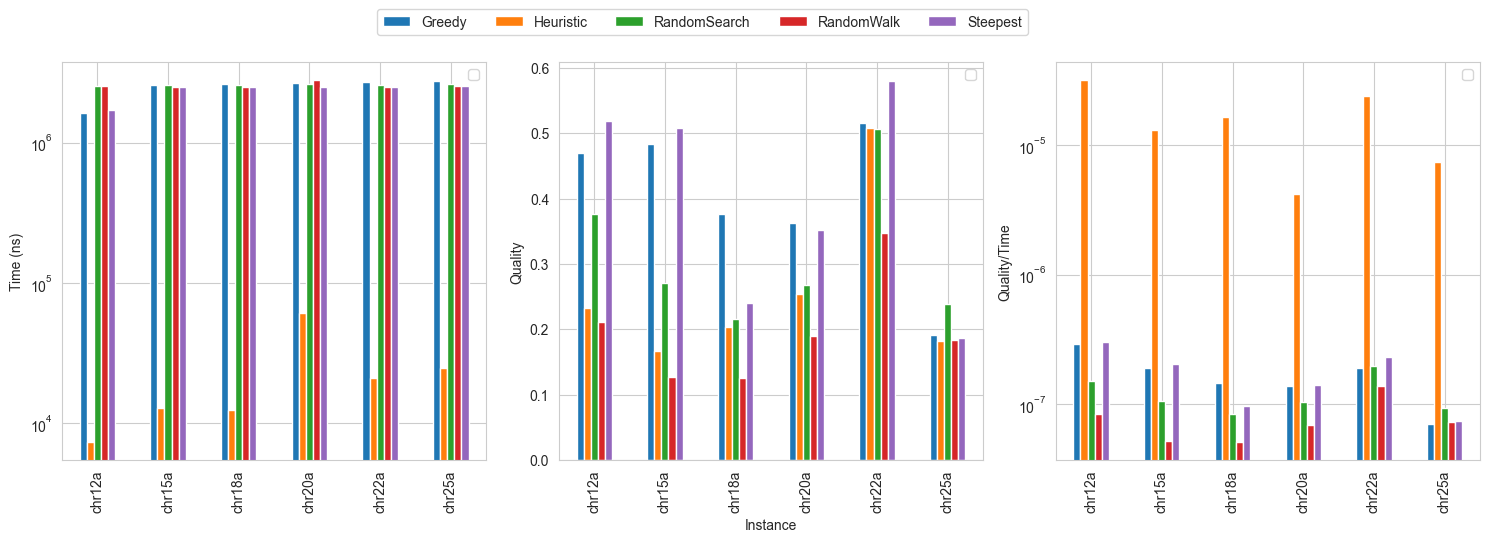

In [14]:
worst_time_df = df.groupby(["Instance", "Algorithm"])["Time"].max().unstack()
worst_quality_df = df.groupby(["Instance", "Algorithm"])["Quality"].min().unstack()
plot_metrics(worst_time_df, worst_quality_df)

### Best time and quality

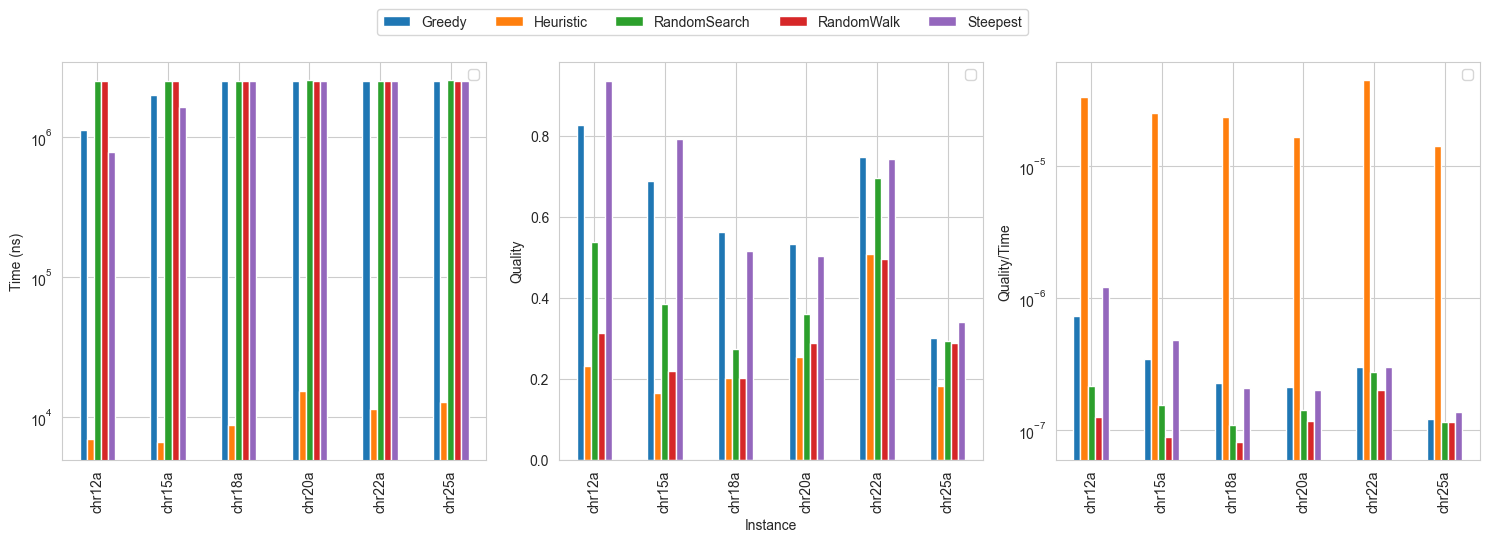

In [15]:
best_time_df = df.groupby(["Instance", "Algorithm"])["Time"].min().unstack()
best_quality_df = df.groupby(["Instance", "Algorithm"])["Quality"].max().unstack()
plot_metrics(best_time_df, best_quality_df)

In [50]:
# fgi, axes = plt.subplots(1, 2, figsize=(15, 5))
# instances = ['chr12a', 'chr15a', 'chr18a', 'chr20a', 'chr22a', 'chr25a']
# instances = df.Instance.unique()
# 
# evaluated_slns_df = df.groupby(["Instance", "Algorithm"])["Evaluations"].mean().unstack()
# evaluated_slns_df = evaluated_slns_df.query("Instance in @instances")
# evaluated_slns_df = evaluated_slns_df[["Greedy", "Steepest", "RandomSearch", "RandomWalk"]]
# evaluated_slns_df.plot(kind='bar', ax=axes[0], ylabel="Evaluations", xlabel="Instance")
# sln_changes_df = df[df['Algorithm'].isin(['Greedy', 'Steepest'])].groupby(["Instance", "Algorithm"])["SlnChanges"].mean().unstack()
# sln_changes_df = sln_changes_df.query("Instance in ['chr12a', 'chr15a', 'chr18a', 'chr20a', 'chr22a', 'chr25a']")
# sln_changes_df.plot(kind='bar', ax=axes[1], ylabel="Solution Changes", logy=False, xlabel="Instance")
# lines, labels = axes[0].get_legend_handles_labels()
# lgd = fgi.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=4)
# axes[0].get_legend().remove()
# axes[1].get_legend().remove()
# # plt.savefig("report/pics/evaluations_sln_changes.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.tight_layout()
# plt.show()

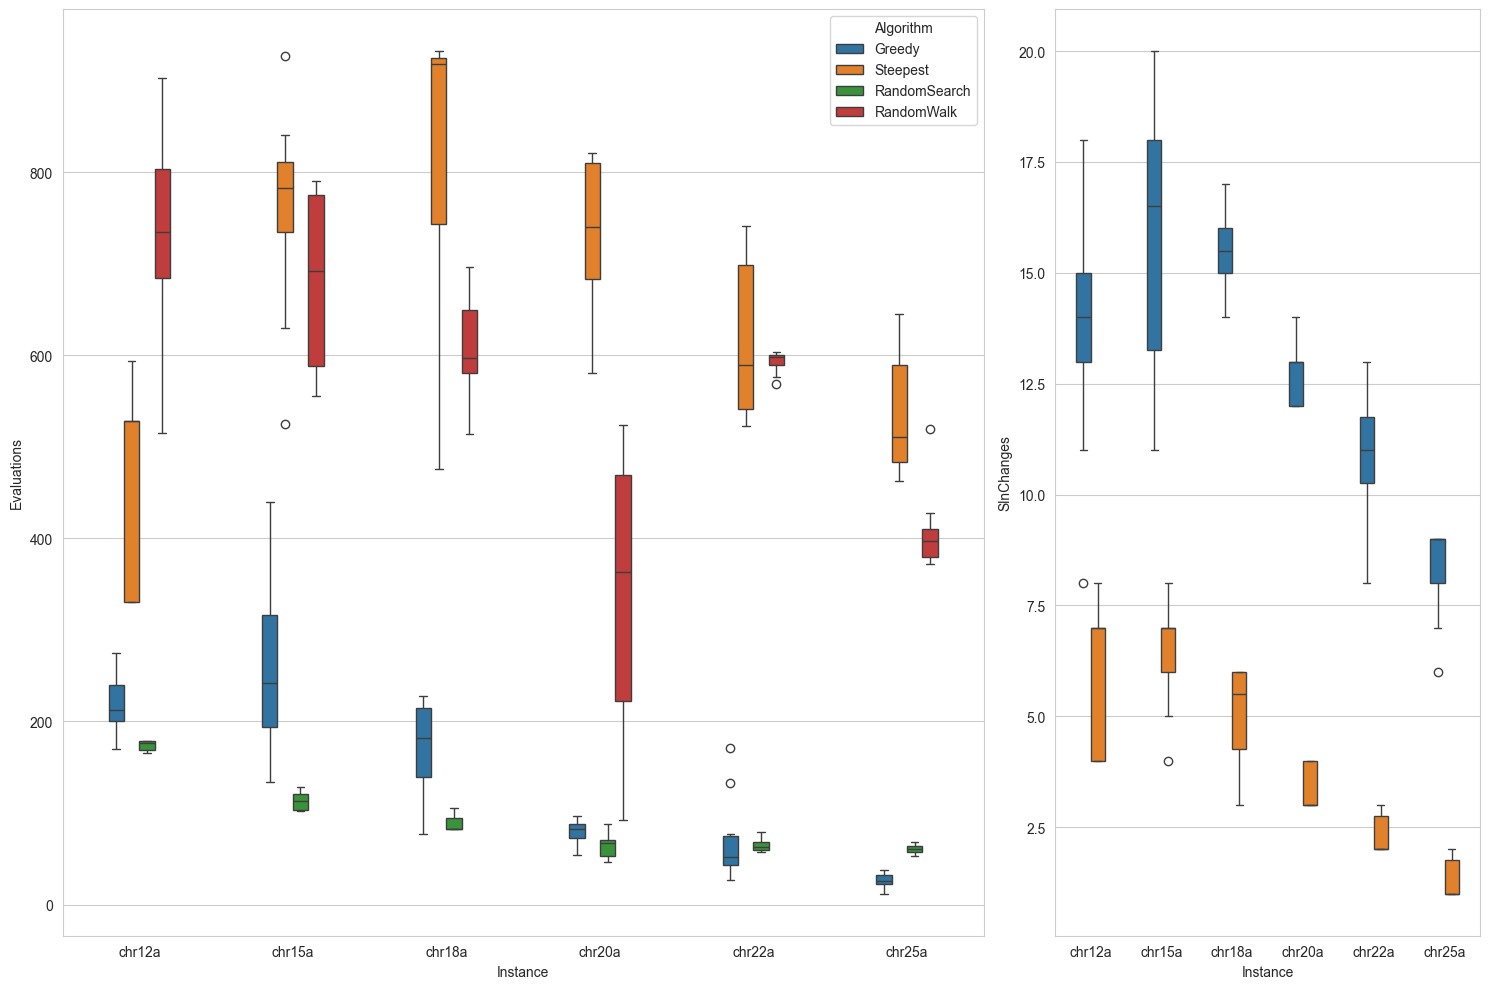

In [55]:
f = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2), )
axs = [ax1, ax2]
to_plot_df = df[['Instance', 'Algorithm', 'Evaluations']].query("Algorithm in ['Greedy', 'Steepest', 'RandomSearch', 'RandomWalk']")
changes_df = df[['Instance', 'Algorithm', 'SlnChanges']].query("Algorithm in ['Greedy', 'Steepest']")
# to_plot_df = to_plot_df.query("Instance in ['chr12a', 'chr15a', 'chr22a', 'chr25a']")
sns.boxplot(ax = axs[0], x='Instance', y='Evaluations', data=to_plot_df, hue='Algorithm', width=0.4)
sns.boxplot(ax = axs[1], x='Instance', y='SlnChanges', data=changes_df, hue='Algorithm', width=0.4)
axs[1].get_legend().remove()
plt.tight_layout()
# plt.savefig("report/pics/evaluations_sln_changes_box_plot.png")
plt.show()

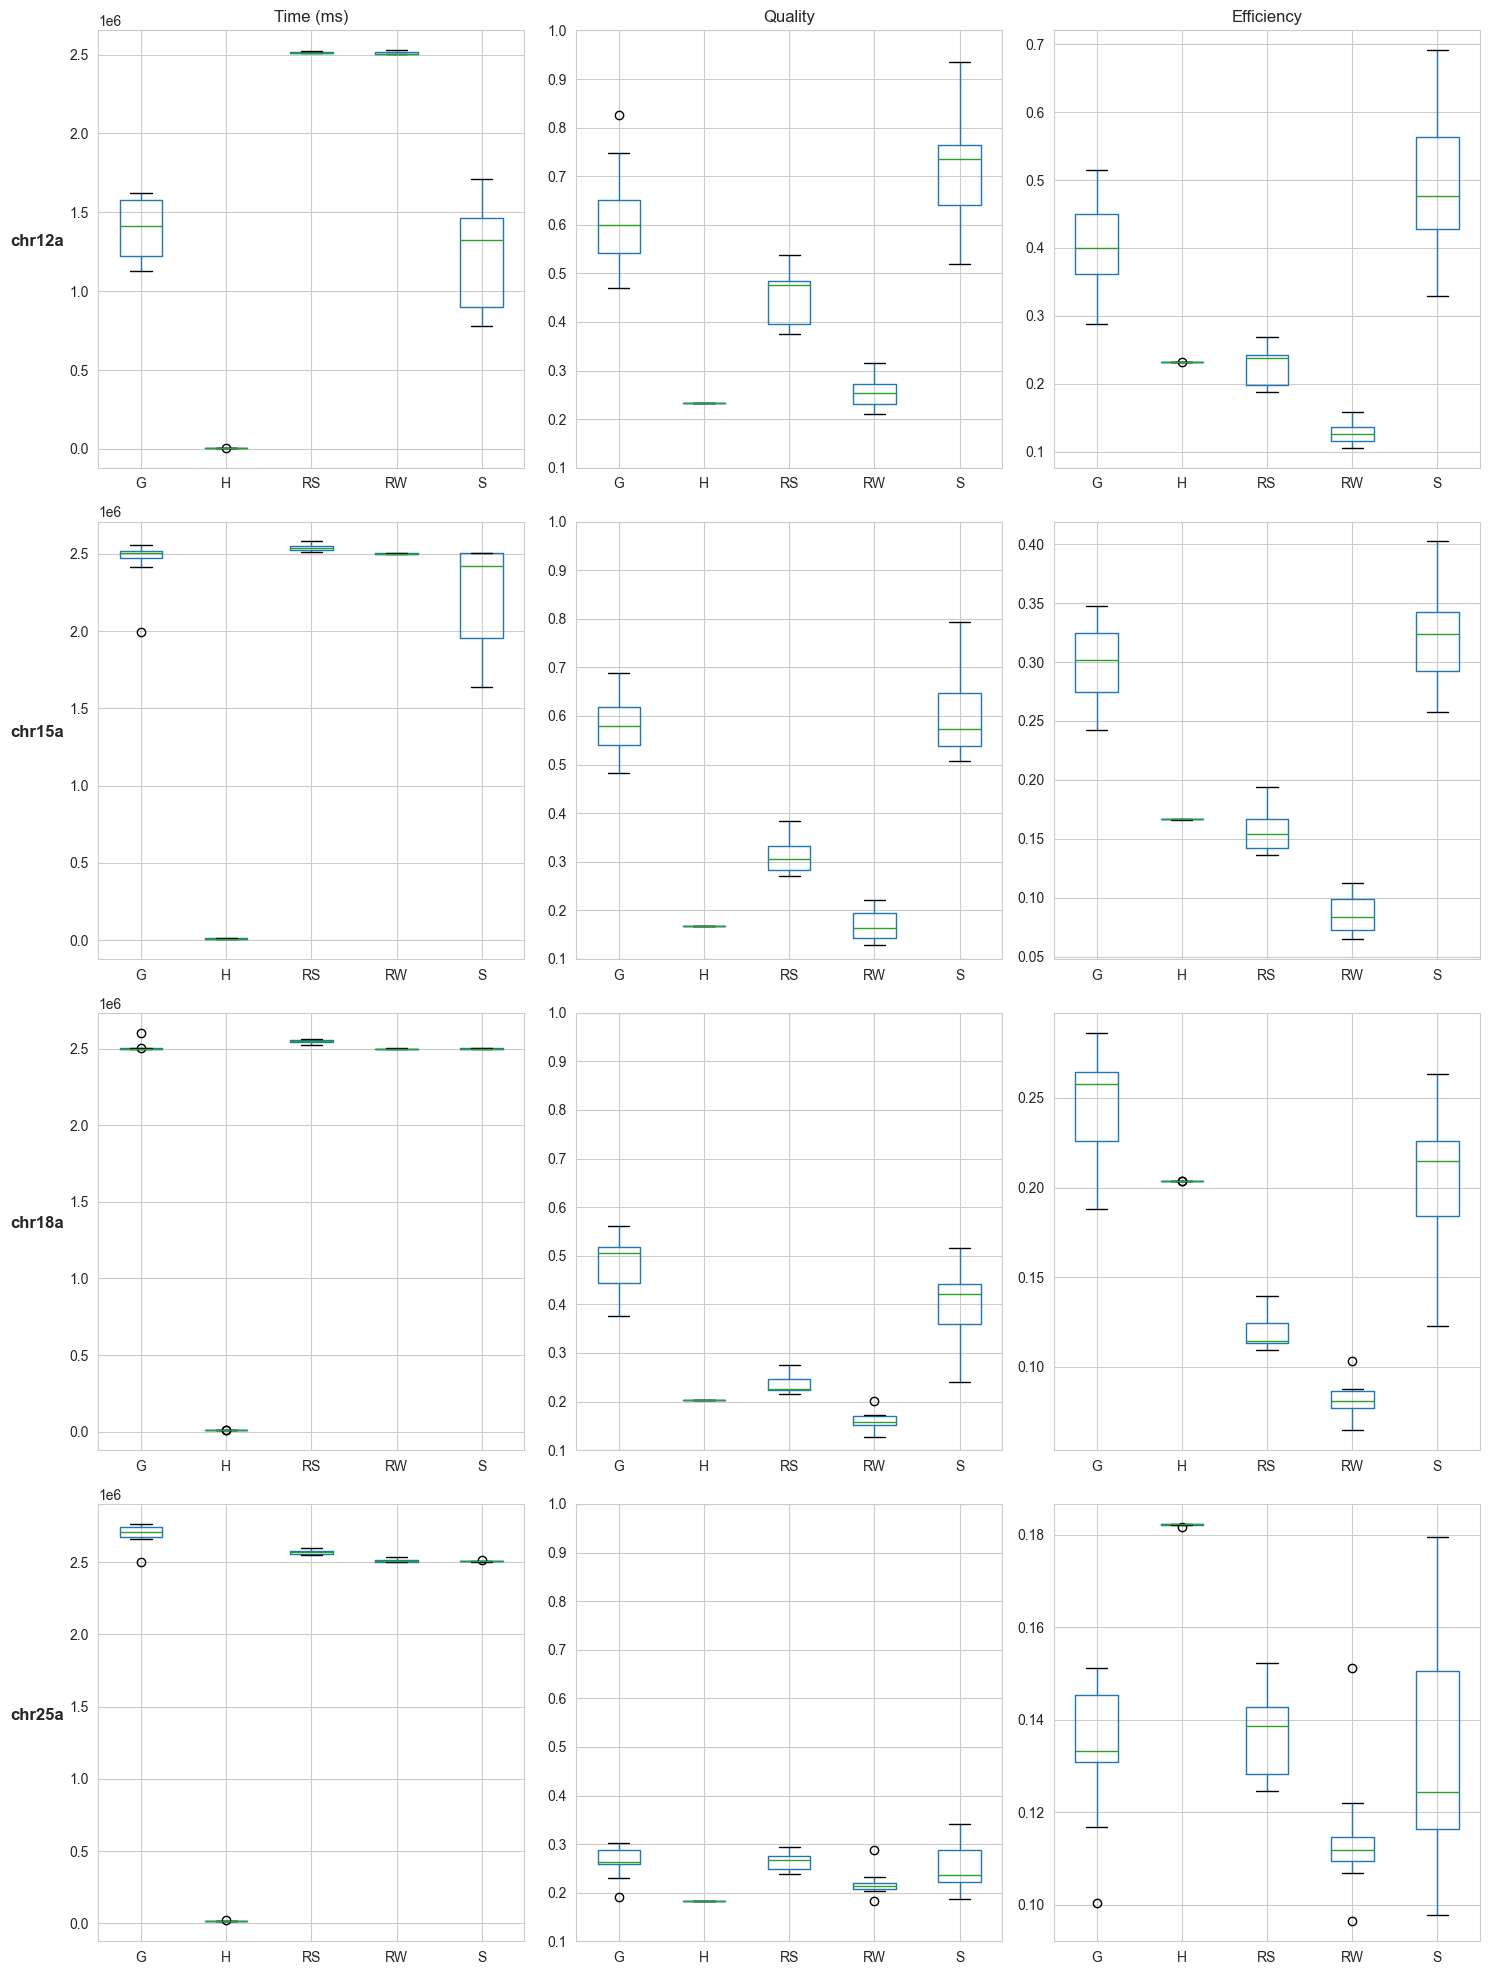

In [54]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
chr_instances = ['chr12a', 'chr15a', 'chr18a', 'chr25a']
# limits = [(0, 3e6), (0, 1), (0., 0.51)]
# chr_instances = df['Instance'].unique()[::2]
for i, instance in enumerate(chr_instances):
    chr_df = df.query("Instance == @instance").copy()
    quality_time_efficiency_box_plots(chr_df, axs[i], hide_titles=False if i == 0 else True)
    axs[i, 0].set_ylabel(instance, rotation=0, ha='right', fontsize='large', fontweight='bold')
    axs[i, 1].set_ylim(0.1, 1)

plt.suptitle(None)
plt.tight_layout()
# plt.savefig("report/pics/time_quality_efficiency_box_plots.png")

plt.show()

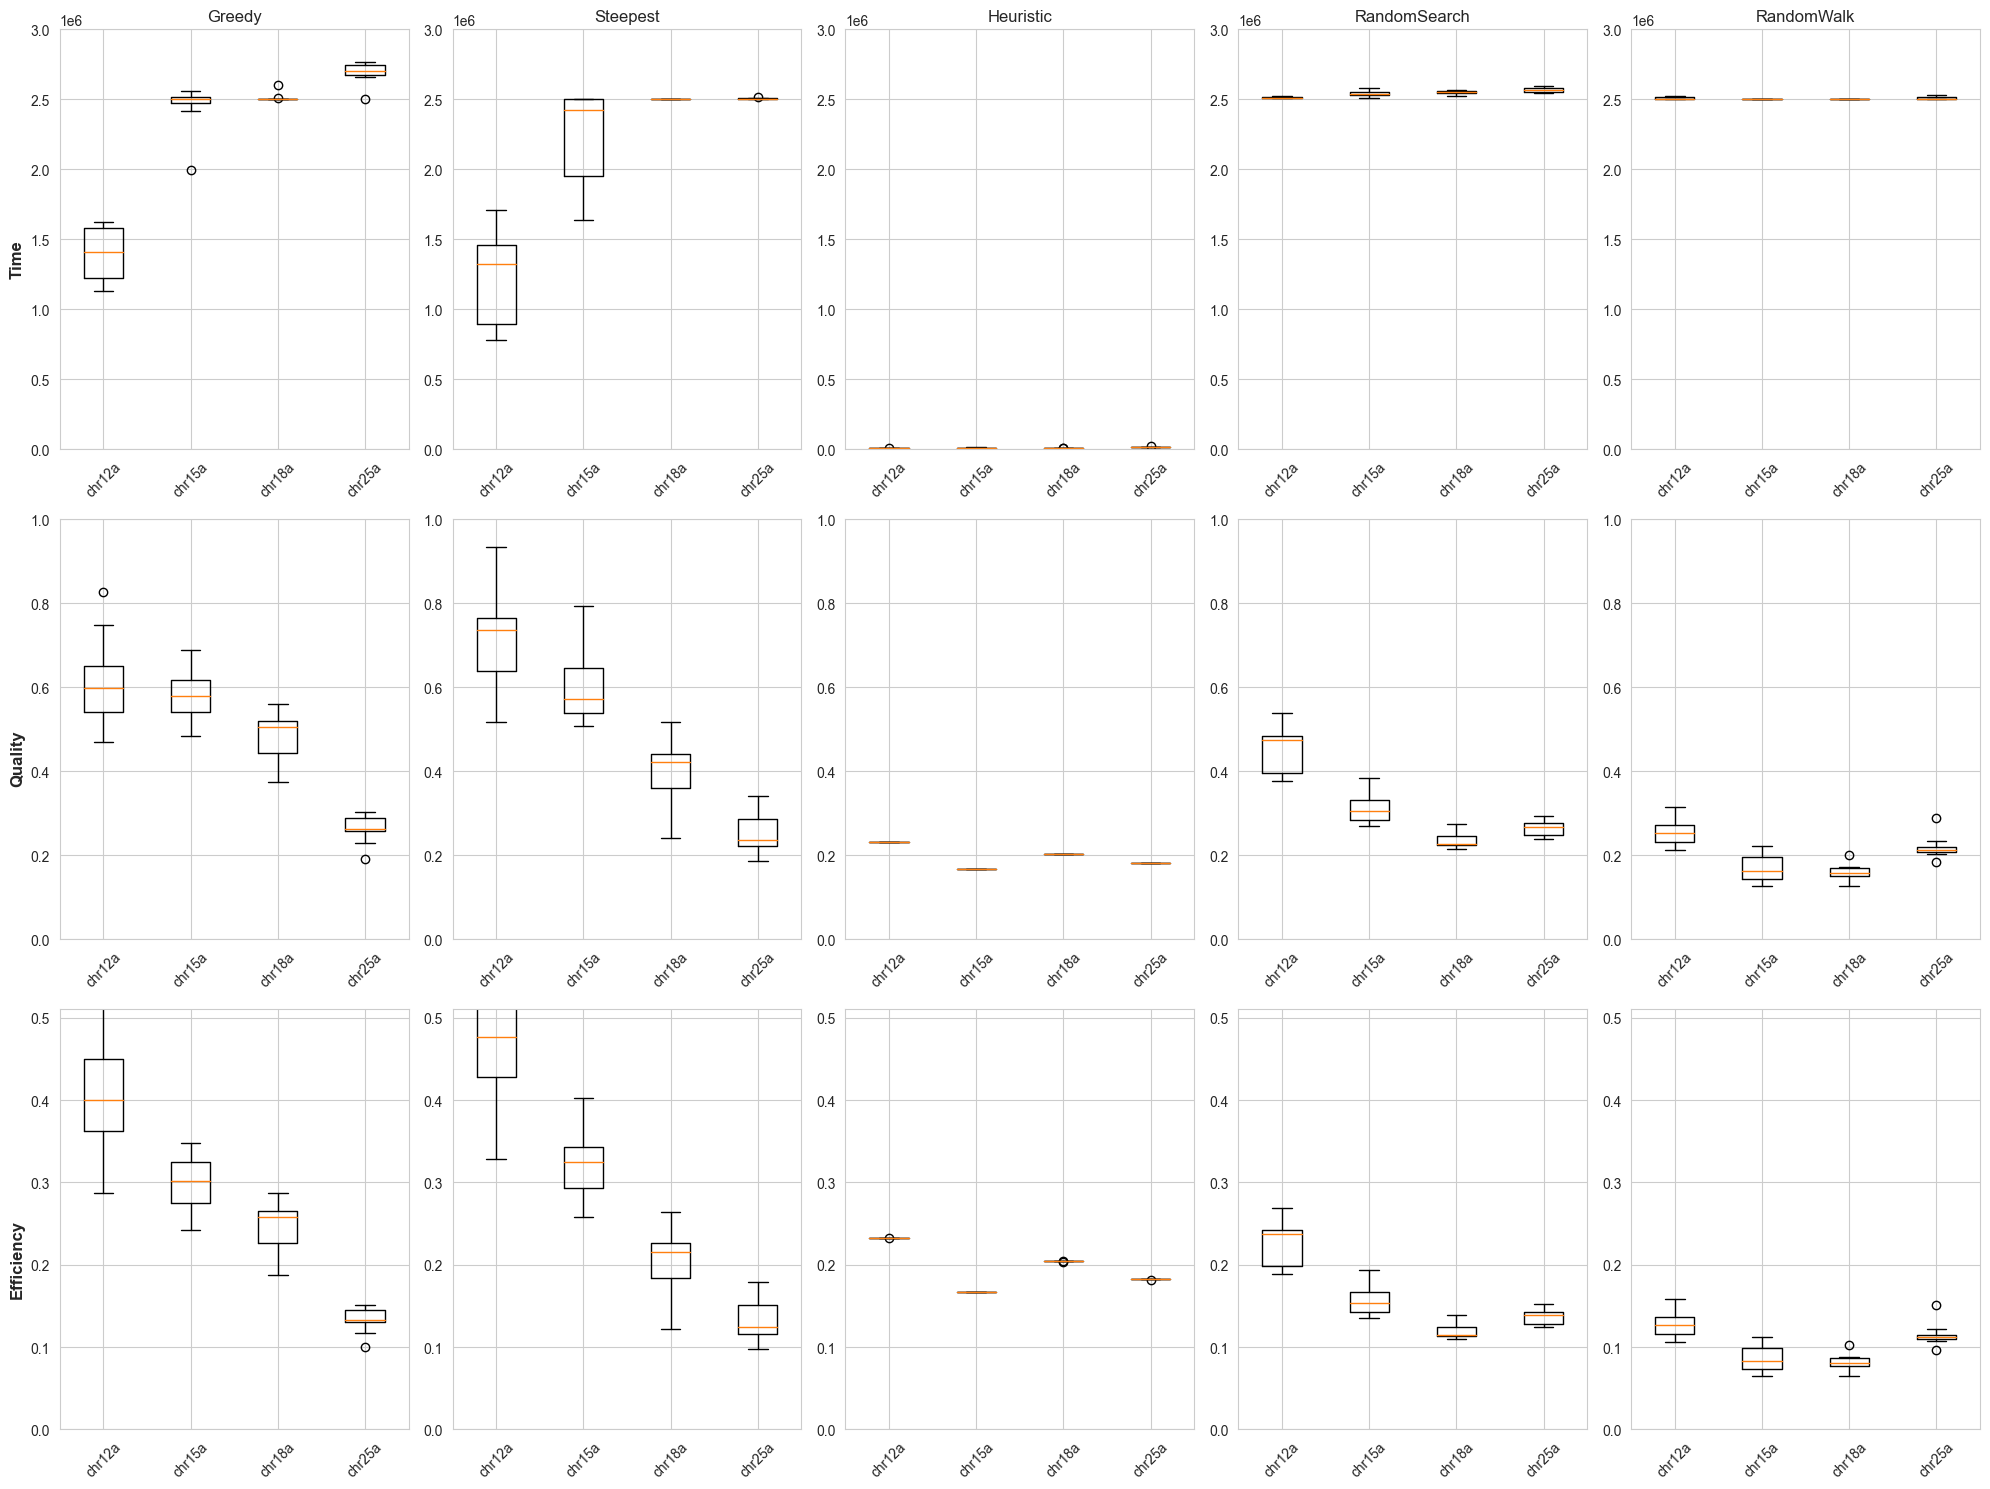

In [28]:
chr_df= df.query("Instance in @chr_instances")
features = ['Time', 'Quality', 'Efficiency']
limits = [(0, 3e6), (0, 1), (0., 0.51)]
fig, axs = plt.subplots(3, 5, figsize=(20, len(features) * 5))

for i, (feature, limit) in enumerate(zip(features, limits)):
    all_alg_feature_box_plot(axs[i], chr_df, feature, hide_titles=False if i==0 else True, y_limits=limit)
    # all_alg_feature_box_plot(axs[i], chr_df, feature, hide_titles=False if i==0 else True, )
    axs[i, 0].set_ylabel(feature, rotation=90, ha='right', fontsize='large', fontweight='bold')

plt.tight_layout()
# plt.savefig("all_alg_feature_box_plot.png")
plt.show()

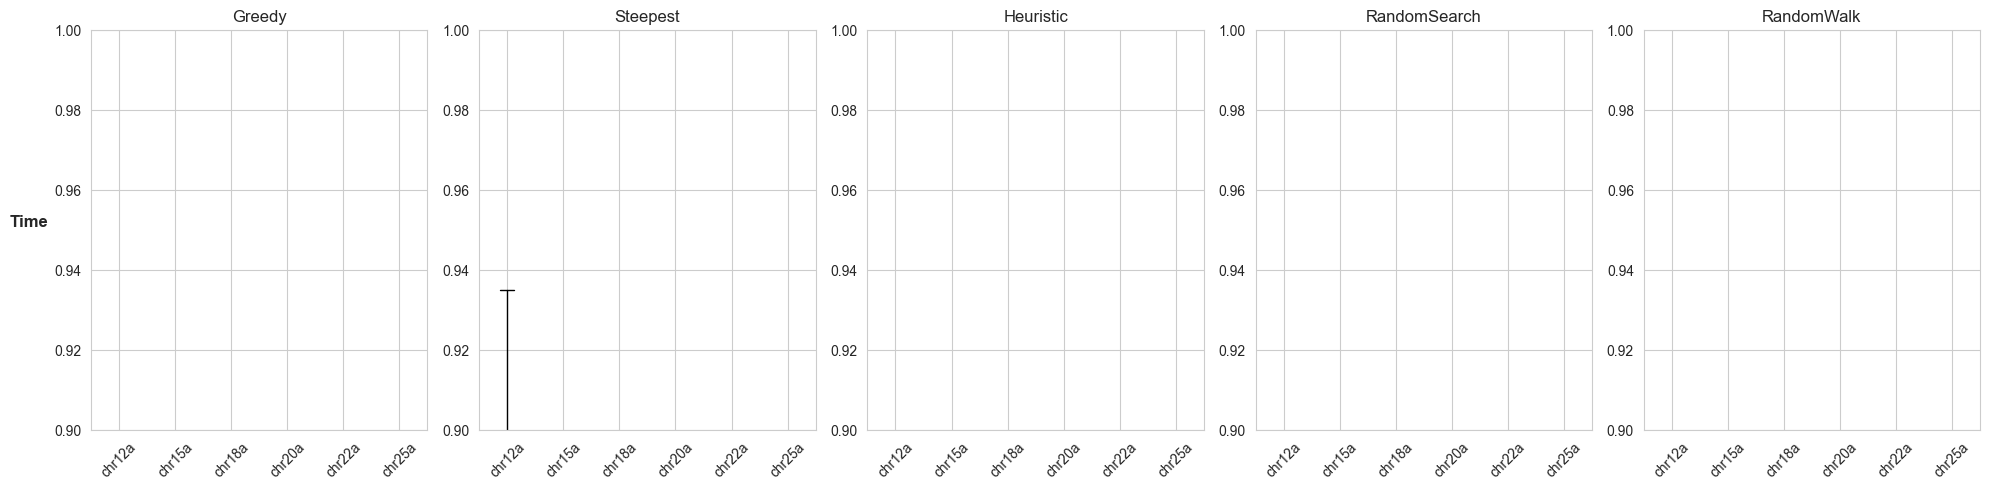

In [52]:
# algs = df['Algorithm'].unique()
# ticks = df['Instance'].unique().tolist()
# 
# fig, axs = plt.subplots(1, 5, figsize=(20, algs.size))
# # all_alg_box_plot(axs, df, 'Time', title="Time (ms)", y_limits=(0, 1))
# axs.ravel()
# 
# for i, alg in enumerate(algs):
#     ax = axs[i]
#     x = df.query("Algorithm == @alg").groupby('Instance')['Quality'].apply(list).to_list()
#     box_plot(ax, x, ticks, title=alg, y_limits=(0.9, 1))
# 
# axs[0].set_ylabel("Time", rotation=0, ha='right', fontsize='large', fontweight='bold')
# # axs[0, 1].set_ylabel("Quality", rotation=0, ha='right', fontsize='large', fontweight='bold')
# # axs[0, 2].set_ylabel("Efficiency", rotation=0, ha='right', fontsize='large', fontweight='bold')
# 
# plt.tight_layout()
# plt.show()